In [40]:
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from torch.autograd import Variable
import csv
%matplotlib inline

In [41]:
titanic=pd.read_csv('titanic_train.csv')
titanic.head()
titanictest=pd.read_csv('titanic_test.csv')
titanictest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We see that some cells like Name, Cabin and Ticket are not really useful, so we remove them from the dataset. Furthermore, Pclass, Sex and Embarked are categorical variables that we would like to have separate columns for. We do that using get_dummies.

In [43]:
#labels=titanic['Survived']
dummy_fields=['Pclass', 'Sex', 'Embarked']
for each in dummy_fields:
    dummies= pd.get_dummies(titanic[each], prefix= each, drop_first=False)
    titanic = pd.concat([titanic, dummies], axis=1)
titanic.head()    

fields_to_drop=['PassengerId', 'Cabin', 'Pclass', 'Name', 'Sex', 'Ticket', 'Embarked']
df=titanic.drop(fields_to_drop,axis=1)
df.head()




,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


Let's see how many NA values are there in the remaining dataset

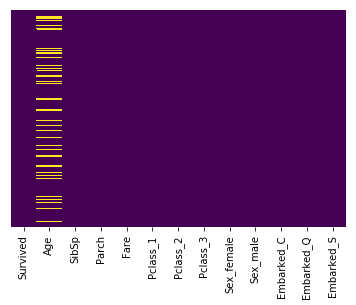

In [44]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')


Count the number of NA in age

In [45]:
df['Age'].isnull().sum()

177

There are 177/891 or about 20% of the age column is NA. The proportion of unknowns is small enough to be filled in with some reasonable assumptions. We could fill up the unknows with the average age but perhaps it is better to make some better guesses, like avergae age by passenger class or average age by sex. Let's see how to do this.

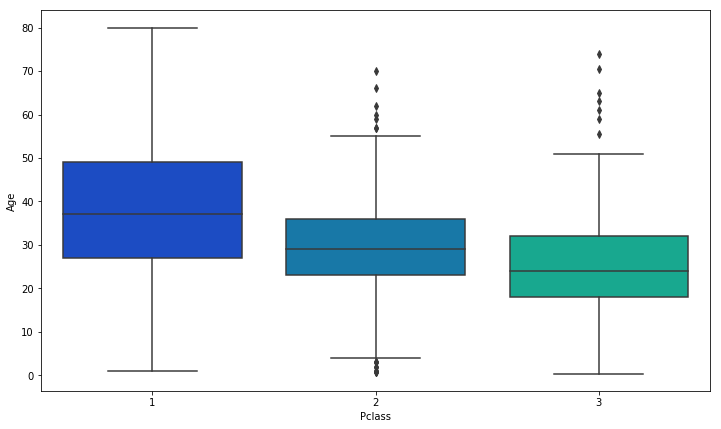

In [46]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=titanic,palette='winter')

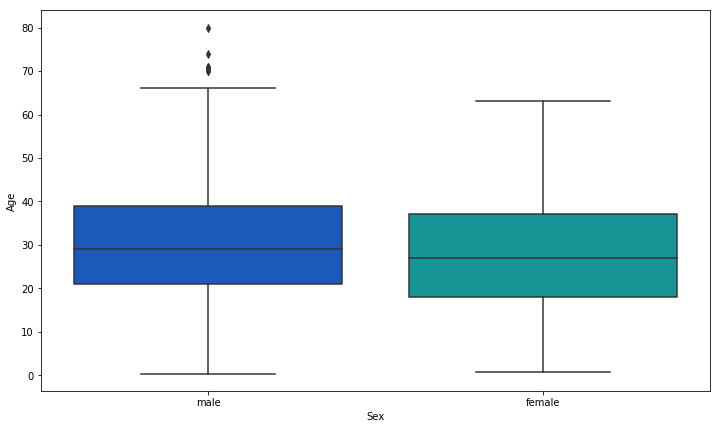

In [47]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Sex',y='Age',data=titanic,palette='winter')

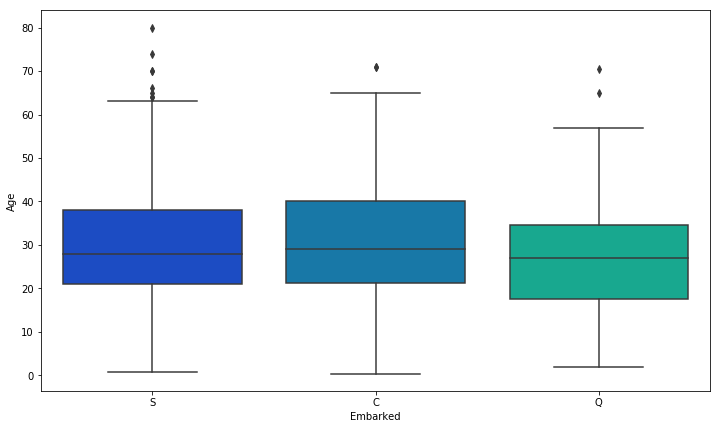

In [48]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Embarked',y='Age',data=titanic,palette='winter')

We see that there is more information when we calculate age by passenger class, instead of sex. So, we'll fill in the missing values by average age per class.

In [49]:
def fill_in_age(x):
    if x['Pclass_1']==1:
        return 37
    elif x['Pclass_2']==1:
        return 29
    else:
        return 25
   

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,25,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,37,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,25,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,37,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,25,0,0,8.0500,0,0,1,0,1,0,0,1


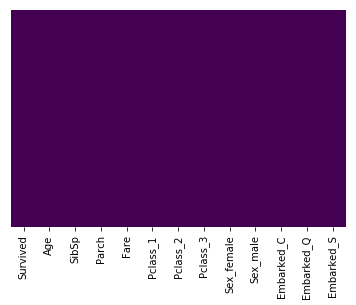

In [50]:
df['Age']=df.apply(fill_in_age, axis=1)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
df.head()

Lastly, let us normalize all the variables.

In [51]:
to_normalize=['Age','Fare']
for each in to_normalize:
    mean, std= df[each].mean(), df[each].std()
    df.loc[:, each]=(df[each]-mean)/std

df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.757876,1,0,-0.502163,0,0,1,0,1,0,0,1
1,1,1.676982,1,0,0.786404,1,0,0,1,0,1,0,0
2,1,-0.757876,0,0,-0.488580,0,0,1,1,0,0,0,1
3,1,1.676982,1,0,0.420494,1,0,0,1,0,0,0,1
4,0,-0.757876,0,0,-0.486064,0,0,1,0,1,0,0,1


In [52]:

dummy_fields=['Pclass', 'Sex', 'Embarked']
for each in dummy_fields:
    dummies= pd.get_dummies(titanictest[each], prefix= each, drop_first=False)
    titanictest = pd.concat([titanictest, dummies], axis=1)
titanic.head()  

fields_to_drop=['Cabin', 'Pclass', 'Name', 'Sex', 'Ticket', 'Embarked']
df_test=titanictest.drop(fields_to_drop,axis=1)
df_test.head()

df_test['Age']=df.apply(fill_in_age, axis=1)

df_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,25,0,0,7.8292,0,0,1,0,1,0,1,0
1,893,37,1,0,7.0000,0,0,1,1,0,0,0,1
2,894,25,0,0,9.6875,0,1,0,0,1,0,1,0
3,895,37,0,0,8.6625,0,0,1,0,1,0,0,1
4,896,25,1,1,12.2875,0,0,1,1,0,0,0,1


In [53]:
to_normalize=['Age','Fare']
for each in to_normalize:
    mean, std= df_test[each].mean(), df_test[each].std()
    df_test.loc[:, each]=(df_test[each]-mean)/std



In [93]:
class set_up_data(data.Dataset):
    def __init__(self, filename):
        data_matrix=filename.values
        data_matrix=torch.from_numpy(data_matrix)
        self.data=data_matrix[:,1:13]
        self.data=self.data.float()
        #self.data= self.data.type(torch.FloatTensor)
        self.target=data_matrix[:,0]
        #self.target=self.target.long()
        #self.target = self.target.type(torch.FloatTensor)
        print('data', self.data)
        
        #self.target = pd_data['Survived']  # 3nd column --> label
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        #return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        return self.data[index], self.target[index]

In [94]:
train_data=set_up_data(df)
train_loader = data.DataLoader(train_data,batch_size=200,num_workers=0)
print(train_loader)



data tensor([[-0.7579,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.6770,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [-0.7579,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.7579,  1.0000,  2.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.6770,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [-0.7579,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000]])


In [95]:
from torch import nn
class my_model(nn.Module):
    def __init__(self,n_in=12,n_hid=1,n_out=1):
        super(my_model,self).__init__()
        self.n_in  = n_in
        self.n_hid = n_hid
        self.n_out = n_out
         
    #self.fc1=nn.Linear(n_in,n_hid)
        
        self.linearlinear =  nn.Sequential(nn.Linear(n_in,n_hid),
                             #nn.ReLU(),
                             #nn.Linear(n_hid,n_out),              
                             nn.Sigmoid())
        
    
    def forward(self,x):
        x = self.linearlinear(x)
        
        return x

In [96]:
from torch import optim

model = my_model()
#model = model.double()
# Cross Entropy loss.
#criterion = torch.nn.functional.mse_loss()

#Stochastic Gradient Descent Optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


#Loss function (Mean Squared loss)
#criterion=nn.MSELoss()
criterion=nn.BCELoss()

In [97]:
%pdb

Automatic pdb calling has been turned ON


In [98]:


epochs = 20
for e in range(epochs):
    running_loss = 0#get images
    for info, labels in train_loader:
        #Flatten images
        #images=images.view(images.shape[0], -1)
        dummy_labels=labels.float()
        #info=info.reshape(info.shape[0],)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        #Forward pass
        output=model(info)

        #Calculate the loss
        loss=criterion(output,dummy_labels)
        
        
        
        #backward propagation
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    
     ## TODO: Implement the validation pass and print out the validation accuracy
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")    
        #print('bias',model.linearlinear[0].bias)
        #print('weight',model.linearlinear[0].weight)
        #print("output",output)
        #print("labels",dummy_labels)
        #print('shape',info.shape)
print("output",output)        

C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.7113051056861878


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.6841864109039306


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.6476614356040955


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.6136708378791809


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.58651704788208


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5661029696464539


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5508435487747192


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.539149010181427


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5298591256141663


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5222252249717713


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.515779846906662


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5102248728275299


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.505361407995224


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.5010510325431824


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.49719452261924746


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.4937196016311646


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.4905728816986084


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.48771334886550904


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.48510839343070983


C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Mario\Anaconda3\lib\site-packages\tor

Training loss: 0.4827313184738159
output tensor([[0.2586],
        [0.5926],
        [0.5400],
        [0.2438],
        [0.1500],
        [0.1507],
        [0.3483],
        [0.4255],
        [0.2586],
        [0.7384],
        [0.1508],
        [0.1660],
        [0.2552],
        [0.3564],
        [0.1510],
        [0.3483],
        [0.4258],
        [0.3944],
        [0.1496],
        [0.1292],
        [0.7961],
        [0.1515],
        [0.3483],
        [0.4439],
        [0.1189],
        [0.1852],
        [0.1996],
        [0.4373],
        [0.1860],
        [0.8425],
        [0.5403],
        [0.2486],
        [0.2345],
        [0.1508],
        [0.1512],
        [0.8629],
        [0.1515],
        [0.1510],
        [0.1996],
        [0.5326],
        [0.1509],
        [0.2552],
        [0.8275],
        [0.2336],
        [0.1515],
        [0.1505],
        [0.0918],
        [0.2354],
        [0.2949],
        [0.8628],
        [0.1172],
        [0.1507],
        [0.5521],
     

In [99]:
print(model)

my_model(
  (linearlinear): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [100]:
#Setting up test data
class set_up_test_data(data.Dataset):
    def __init__(self, filename):
        data_matrix=filename.values
        data_matrix=torch.from_numpy(data_matrix)
        self.data=data_matrix[:,1:13]
        self.data=self.data.float()
        #self.data= self.data.type(torch.FloatTensor)
        #self.target=data_matrix[:,0]
        #self.target=self.target.long()
        #self.target = self.target.type(torch.FloatTensor)
        #print('target type', self.data.shape)
        self.passid=data_matrix[:,0]
        
        #self.target = pd_data['Survived']  # 3nd column --> label
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        #return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        return self.data[index],self.passid[index]

In [101]:
test_data=set_up_test_data(df_test)
test_loader = data.DataLoader(test_data,batch_size=200,num_workers=0)


In [102]:
predictions = np.array([[]])
with open('survivors_titanic_test1.csv','w') as newFile:
    newFileWriter = csv.writer(newFile,escapechar=' ',quoting=csv.QUOTE_NONE)
    newFileWriter.writerow(['PassengerId','Survived'])
    with torch.no_grad():
        for info,passid in test_loader:
            output=model(info)
            for i in range(len(info)):
                #np.append(predictions, b[i])
                newFileWriter.writerow('\n')
                passid1=passid[i].numpy().astype(int)
                if output[i]>0.5:
                    newFileWriter.writerow([passid1,'1'])
                    predictions=np.append(predictions,'1')
                else:
                    newFileWriter.writerow([passid1,'0'])
                    predictions=np.append(predictions,'0')
print("shape", predictions.shape)
result = pd.DataFrame(columns=["PassengerId", "Survived"])
result["PassengerId"] = df_test['PassengerId']
result["Survived"] = predictions
result.to_csv("Submission-tf1.csv", index=False)                    
        

shape (418,)


In [ ]:
#Validation/Test

ps=[]
        with torch.no_grad():
            for info,labels in test_loader:
                ps=model(info)
                ps[ps>0]=1
                #top_p, top_class=ps.topk(1,dim=1)
                equals= ps == labels.view(*top_class.shape)
                accuracy=torch.mean(equals.type(torch.FloatTensor))
                print(f'Accuracy: {accuracy.item()*100}%')

In [22]:
# Taining.
for k, (data, target) in enumerate(train_loader):
    # Definition of inputs as variables for the net.
    # requires_grad is set False because we do not need to compute the 
    # derivative of the inputs.
    data   = Variable(data,requires_grad=False)
    target = Variable(target.float(),requires_grad=False)
    
    
    # Set gradient to 0.
    optimizer.zero_grad()
    # Feed forward.
    pred = model(data)
    # Loss calculation.
    loss = torch.nn.functional.mse_loss(pred,target.view(-1))
    # Gradient calculation.
    loss.backward()
    
    # Print loss every 10 iterations.
    if k%10==0:
        print('Loss {:.4f} at iter {:d}'.format(loss.item(),k))
        
    # Model weight modification based on the optimizer. 
    optimizer.step()

Loss 0.3450 at iter 0


pd_data = pd.read_csv(filename).values   # Read data file.
        dummy_fields=['Pclass', 'Sex', 'Embarked']
        for each in dummy_fields:
            dummies= pd.get_dummies(pd_data[each], prefix= each, drop_first=False)
            pd_data= pd.concat([pd_data, dummies], axis=1)
        pd_data['Age']=pd_data.apply(fill_in_age, axis=1)
        to_normalize=['Age','Fare']
        for each in to_normalize:
            mean, std= pd_data[each].mean(), pd_data[each].std()
            pd_data.loc[:, each]=(pd_data[each]-mean)/std
        fields_to_drop=['PassengerId', 'Cabin', 'Pclass', 'Name', 'Sex', 'Ticket', 'Embarked','Survived']    
        self.data=pd_data.drop(fields_to_drop,axis=1)

In [ ]:
#Experimenting
from torch import nn
class my_model(nn.Module):
    def __init__(self,n_in=12,n_hidden=5,n_out=1):
        super(my_model,self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
         
        self.linearlinear =  nn.Sequential(nn.Linear(12,6),
                      nn.ReLU(),
                      nn.Linear(6,1),
                      nn.ReLU())             # -Log(Softmax probability).
    
    def forward(self,x):
        x = self.linearlinear(x)
        return x